In [31]:
import re
import string
import scipy
import pickle
import os,glob
import pandas as pd
import numpy as np
import seaborn as sns
import warnings 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import *
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from prettytable import PrettyTable
from joblib import dump, load
from astropy.table import Table, Column
from sklearn.utils import shuffle

warnings.filterwarnings("ignore")

In [32]:
# Importer les données
dossier = ""

# Construire le chemin complet du fichier
chemin_fichier = os.path.join(dossier, 'NewData.xlsx')

# Lire le fichier Excel
dataset = pd.read_excel(chemin_fichier)

print(" Corpus:")
dataset.sample(20)

 Corpus:


,Tweet,Sentiment_Cible
2649,Support local businesses/organisations in #Bat...,Negative
1476,Deliveroo Winchester: Most popular takeaways i...,Positive
3948,Deliver packages to your client without leavin...,Positive
792,Obviously the main takeaway from #NakedAttract...,Positive
1935,Pls help to my repuess refund I have many try ...,Neutral
479,Cook breakfast or Uber eats for $95.00 hmm 🤔,Neutral
2160,The United States online #food #delivery marke...,Neutral
58,"Brain dead people use Uber Eats or Instacart, ...",Negative
3125,This job might be a great fit for you: Restaur...,Positive
3771,Lost fast-food delivery worker crashes college...,Negative


In [33]:
# Afficher le nombre de tweets et de variables
print(f'Nombre de Tweets : {dataset.shape}')

Nombre de Tweets : (4003, 2)


# PRE-TRAITEMENTS

### 1)Détection et suppression des doublons

In [34]:
# afficher les  doublons et ensuite les supprimer (Ref: https://gist.github.com/darryllamoureux/28ad89f554a1fa87e82506fb3afbcada)
print( dataset.duplicated().sum(), 'Résultat Doublons')
print(dataset.isnull().sum().sum(), 'Résultat Valeurs Manquantes')

64 Résultat Doublons
0 Résultat Valeurs Manquantes


In [35]:
dataset.drop_duplicates(inplace=True)
print(dataset.shape)

(3939, 2)


### 2) Traduction des Emojis en description textuelle

In [36]:
import pandas as pd
import emoji

#définir une fonction pour convertir les emojis en texte
def convert_emojis_text(text):
    emoji_list = emoji.emoji_list(text)
    for e in emoji_list:
        emoji_tag = e['emoji']
        text = text.replace(emoji_tag, f" {emoji.demojize(emoji_tag)} ")
    return text

# Conserver le texte original dans une nouvelle colonne 'texte'
dataset['Tweet'] = dataset['Tweet']

# Appliquer la conversion des emojis sur 'Tweet_Text' et stocker le résultat dans 'Texte_Emoji'
dataset['TexteEmoji'] = dataset['Tweet'].apply(convert_emojis_text)


# Sélectionner et réorganiser les colonnes pour le résultat final
dataset = dataset[['Tweet', 'TexteEmoji', 'Sentiment_Cible']]

# Sauvegarder le DataFrame modifié dans un fichier CSV
dataset.to_csv('TweetConver.csv', index=False)

print(dataset.head(10))

                                               Tweet  \
0  Who orders Uber eats from a place down the str...   
1            Not Uber Eats going up on their fees???   
2  London actually isn’t real wdym the Uber eats ...   
3  everytime i tip extra on uber eats, my food ge...   
4  The Uber eats driver said my name popped up as...   
5  When the Uber  eats driver makes you walk down...   
6  I took care of my weed problem, next is my doo...   
7  idk how you can watch that and not have your m...   
8  Positive takeaway from the loss is I rage clea...   
9           I'm gonna need a takeaway here, Seahawks   

                                          TexteEmoji Sentiment_Cible  
0  Who orders Uber eats from a place down the str...         Neutral  
1            Not Uber Eats going up on their fees???         Neutral  
2  London actually isn’t real wdym the Uber eats ...        Positive  
3  everytime i tip extra on uber eats, my food ge...        Negative  
4  The Uber eats driver said

### 3) Nettoyage des données avec suppression de mots vides

In [37]:
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import os,glob
import numpy as np

[nltk_data] Downloading package stopwords to C:\Users\Freddine
[nltk_data]     Djoutchet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Freddine
[nltk_data]     Djoutchet\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [38]:
# Référence (https://github.com/kenypatel233/SentimentAnalysis/blob/main/Sentiment%20Analysis.ipynb)
def pretraitement(text):
    # Vérifier si 'text' est une chaîne de caractères
    if not isinstance(text, str):
        return ""  # Retourne  vide si 'text' n'est pas une chaîne de caractères
    # Suppression des URLs
    text = re.sub(r'http\S+', '', text)
    # Suppression des noms commençant par @
    text = re.sub(r'@\w+', '', text)
    # Suppression des hashtags
    text = re.sub(r'#\w+', '', text)
    # Suppression des valeurs numériques
    text = re.sub(r'\d+', '', text)
    # Suppression des caractères non-alphabéthiques
    text=re.sub('[^A-Za-z\s]+',"", text)
    # Suppression des punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Suppression des espaces inutiles
    text = re.sub(r'\s+', ' ', text)
    # Convertir le texte en minuscules
    text = text.lower()
    # Suppression des caractères simples
    text = re.sub(r'\b\w\b', '', text)
    # Supprimer les espaces supplémentaires après avoir supprimé les caractères simples
    text = re.sub(r'\s+', ' ', text).strip()
     # Supprimer les mots vides
    stop_words = stopwords.words('english')
    text = ' '.join(word for word in text.split() if word.lower() not in stop_words)

    return text

# Conserver le texte original dans une nouvelle colonne 'texte'
dataset['Tweet'] = dataset['Tweet']

# Appliquer le prétraitement sur la variable TexteEmoji 
dataset['TexteEmoji'] = dataset['TexteEmoji'].apply(pretraitement)
dataset.to_csv('Tweetprofil.csv', index=False)
# reinitialiser les index
dataset = dataset.reset_index()

dataset.head(100)

,index,Tweet,TexteEmoji,Sentiment_Cible
0,0,Who orders Uber eats from a place down the str...,orders uber eats place street,Neutral
1,1,Not Uber Eats going up on their fees???,uber eats going fees,Neutral
2,2,London actually isn’t real wdym the Uber eats ...,london actually isnt real wdym uber eats drive...,Positive
3,3,"everytime i tip extra on uber eats, my food ge...",everytime tip extra uber eats food gets delive...,Negative
4,4,The Uber eats driver said my name popped up as...,uber eats driver said name popped tequila,Neutral
...,...,...,...,...
95,97,yer bird gets her elfbars off deliveroo https:...,yer bird gets elfbars deliveroo,Neutral
96,98,I just ordered a beer at this food place in Li...,ordered beer food place lisbon said takeaway f...,Neutral
97,99,"Almost 400 yards of offense, a takeaway and a ...",almost yards offense takeaway field goal block...,Neutral
98,100,i seen a uber eats commercial wit light bulb w...,seen uber eats commercial wit light bulb wrist...,Positive



Nombre de sentiments par classe


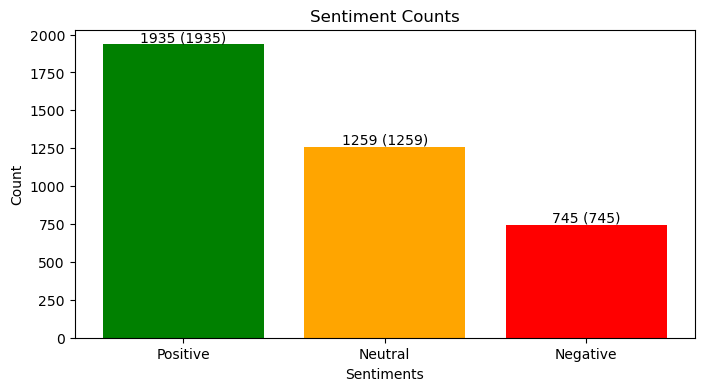

In [40]:
# # Compter la répartition des sentiments par classe ( Ref: https://github.com/LeCoinStat/100JoursDeML/blob/main/08_NLP/01_Analyse_Sentiment/01_Twitter_Sentiment_Analysis.ipynb)

sentiment_counts = dataset['Sentiment_Cible'].value_counts()
# Calculer la proportion pour chaque valeur de sentiments
sentiment_proportion = dataset['Sentiment_Cible'].value_counts()

# Set the figure size
plt.figure(figsize=(8, 4))
# Define a color for each sentiment
colors = {'Positive': 'green', 'Neutral': 'orange', 'Negative': 'red'}

# Création d'un graphique en bare
plt.bar(sentiment_counts.index, sentiment_counts.values,color=[colors[sent] for sent in sentiment_counts.index])

# Ajouter les étiquettes des barres (nombre d'occurrences et proportion)
for i, count in enumerate(sentiment_counts):
    proportion = sentiment_proportion[i]
    plt.text(i, count, f"{count} ({proportion:})", ha='center', va='bottom')
    
    
# labéliser le graphique
plt.xlabel('Sentiments')
plt.ylabel('Count')
plt.title('Sentiment Counts')
plt.savefig('Sentimentdistribution.png')
print("\nNombre de sentiments par classe")


# Show the bar graph
plt.show()

### 4) Tokenisation

In [41]:
from nltk.tokenize import word_tokenize
Tokens = dataset['TexteEmoji'].apply(word_tokenize)
Tokens = Tokens.to_frame()
label_dataset=pd.DataFrame(dataset["Sentiment_Cible"])
Tokens=Tokens.join(label_dataset)

print("\nRésultat Tokenization :")

Tokens.head(10)



Résultat Tokenization :


,TexteEmoji,Sentiment_Cible
0,"[orders, uber, eats, place, street]",Neutral
1,"[uber, eats, going, fees]",Neutral
2,"[london, actually, isnt, real, wdym, uber, eat...",Positive
3,"[everytime, tip, extra, uber, eats, food, gets...",Negative
4,"[uber, eats, driver, said, name, popped, tequila]",Neutral
5,"[uber, eats, driver, makes, walk, downstairs, ...",Neutral
6,"[took, care, weed, problem, next, doordashuber...",Neutral
7,"[idk, watch, main, takeaway, cant, believe, co...",Positive
8,"[positive, takeaway, loss, rage, cleaned, part...",Negative
9,"[im, gon, na, need, takeaway, seahawks]",Neutral


### 5) Description des données dans chaque catégorie

### description vocabulaire (adjectifs) les plus utilisés par catégorie de sentiments

In [43]:
from collections import Counter
# Filtrer les tokens par sentiment
pos_tokens = Tokens[Tokens['Sentiment_Cible'] == 'Positive']['TexteEmoji'].sum()
neg_tokens = Tokens[Tokens['Sentiment_Cible'] == 'Negative']['TexteEmoji'].sum()
neu_tokens = Tokens[Tokens['Sentiment_Cible'] == 'Neutral']['TexteEmoji'].sum()

# Fonctions pour obtenir les mots et adjectifs les plus communs
def get_tokens(docx, num=20):
    word_tokens = Counter(docx)
    most_common = word_tokens.most_common(num)
    result = dict(most_common)
    return result

def get_adj_tokens(tokens, num=20):   
    tagged_tokens = nltk.pos_tag(tokens)
    adj_tokens = [word.lower() for word, pos in tagged_tokens if pos.startswith('JJ')]
    word_tokens = Counter(adj_tokens)
    most_common = word_tokens.most_common(num)
    result = dict(most_common)
    return result

# Utilisation des fonctions
print(get_tokens(pos_tokens))
print(get_adj_tokens(pos_tokens))
                     


{'delivery': 1221, 'food': 948, 'fast': 501, 'takeaway': 366, 'uber': 311, 'restaurant': 279, 'eats': 276, 'amp': 248, 'deliveroo': 229, 'order': 193, 'get': 190, 'time': 180, 'new': 155, 'driver': 136, 'like': 119, 'first': 116, 'one': 112, 'service': 110, 'today': 107, 'dont': 100}
{'uber': 259, 'new': 155, 'good': 82, 'first': 76, 'restaurant': 76, 'next': 65, 'free': 63, 'great': 63, 'best': 57, 'available': 56, 'deliveroo': 55, 'big': 53, 'live': 53, 'much': 52, 'many': 49, 'local': 44, 'amp': 44, 'full': 44, 'last': 43, 'minimum': 35}


In [44]:
most_common_pos_adj = get_adj_tokens(pos_tokens)
most_common_neu_adj = get_adj_tokens(neu_tokens)
most_common_neg_adj = get_adj_tokens(neg_tokens)

In [45]:
pos_df = pd.DataFrame(most_common_pos_adj.items(),columns=['words','scores'])
neg_df = pd.DataFrame(most_common_neg_adj.items(),columns=['words','scores'])
neu_df = pd.DataFrame(most_common_neu_adj.items(),columns=['words','scores'])
     

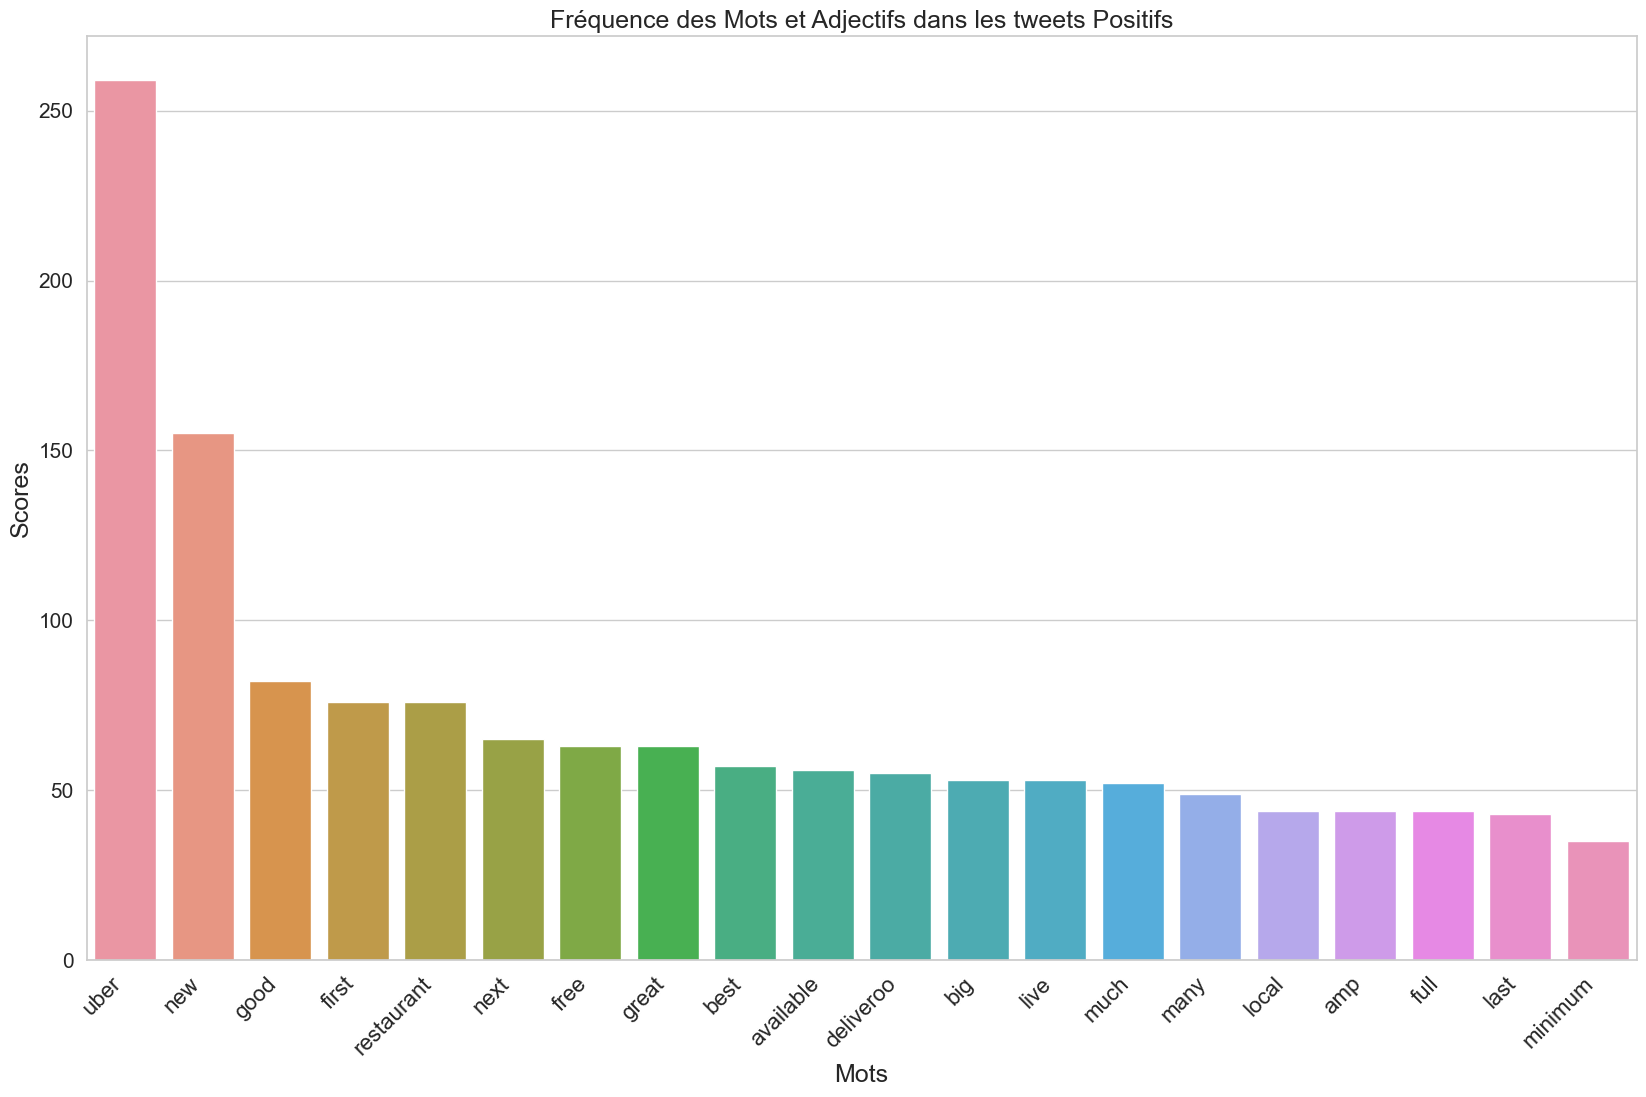

In [75]:
# plot
plt.figure(figsize=(20,12))
sns.barplot(x='words',y='scores',data=pos_df)
plt.title('Fréquence des Mots et Adjectifs dans les tweets Positifs', fontsize=18)  
plt.xlabel('Mots', fontsize=18)  
plt.ylabel('Scores', fontsize=18)  
plt.xticks(rotation=45, fontsize=16, ha='right') 
plt.yticks(fontsize=15) 

plt.savefig('AdjPositiV.png', bbox_inches='tight')
plt.show()


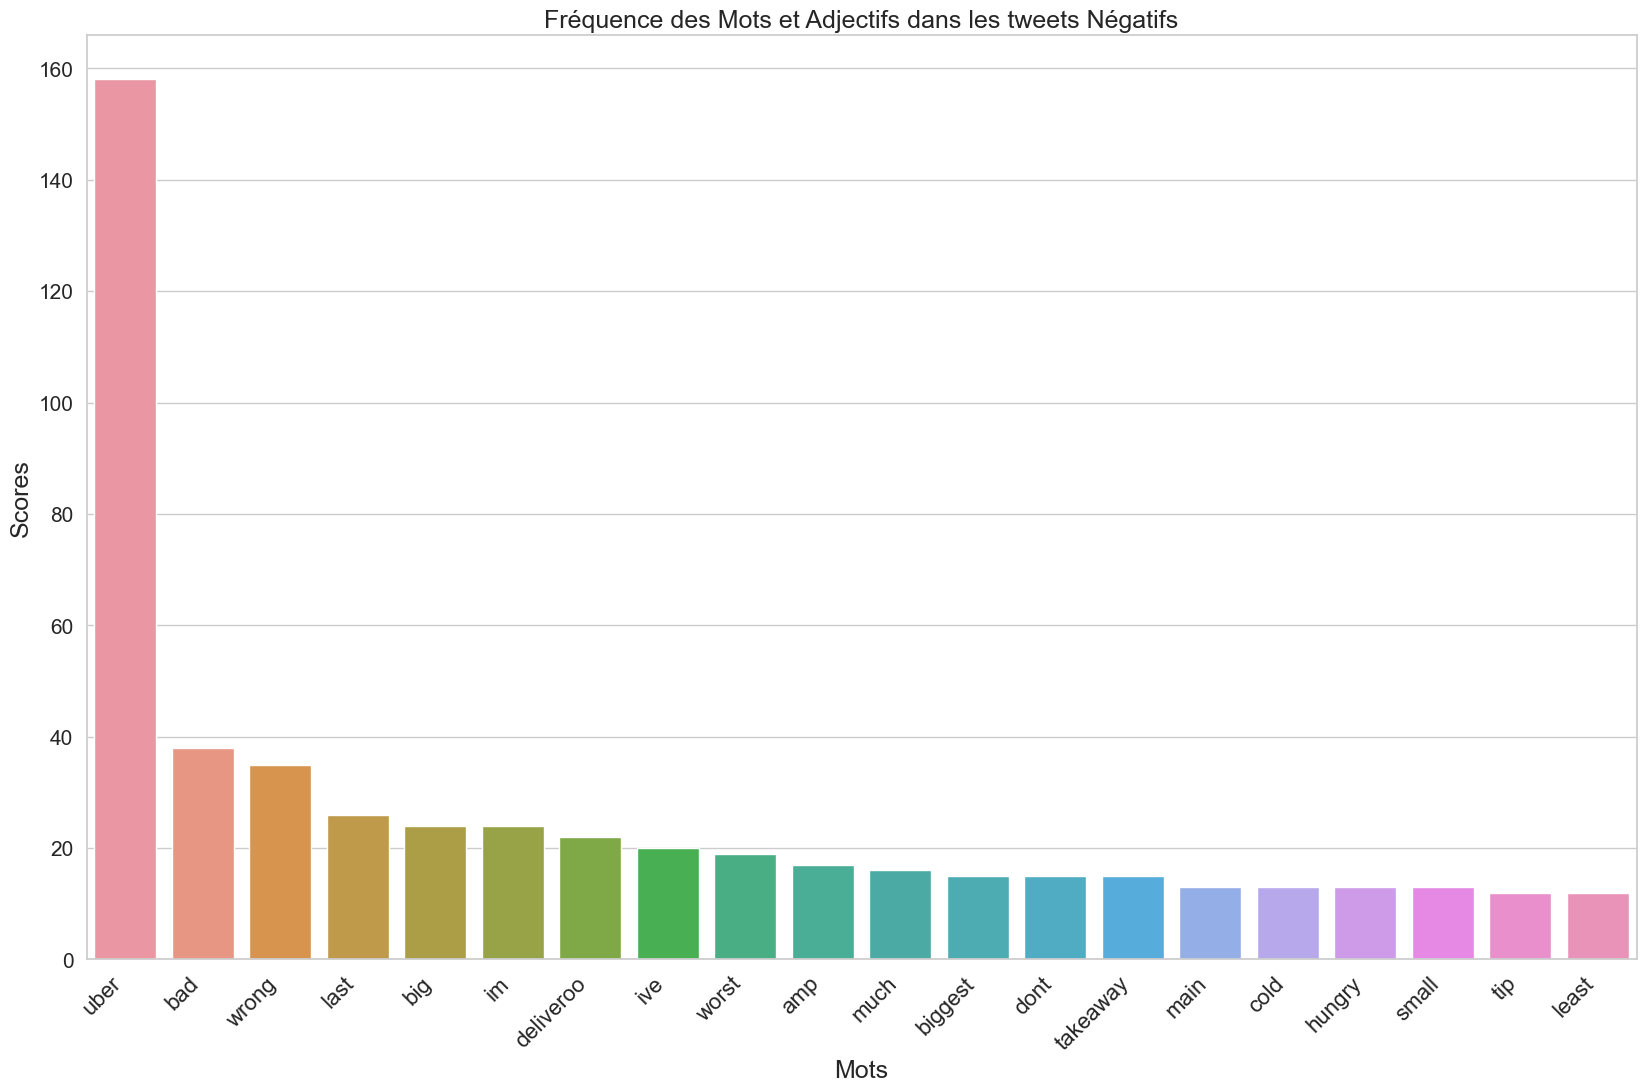

In [76]:
plt.figure(figsize=(20,12))
sns.barplot(x='words',y='scores',data=neg_df)
plt.title('Fréquence des Mots et Adjectifs dans les tweets Négatifs', fontsize=18)
plt.xlabel('Mots', fontsize=18)  
plt.ylabel('Scores', fontsize=18)  
plt.xticks(rotation=45, fontsize=16, ha='right') 
plt.yticks(fontsize=15) 
plt.savefig('AdjNegatiV.png', bbox_inches='tight')
plt.show()

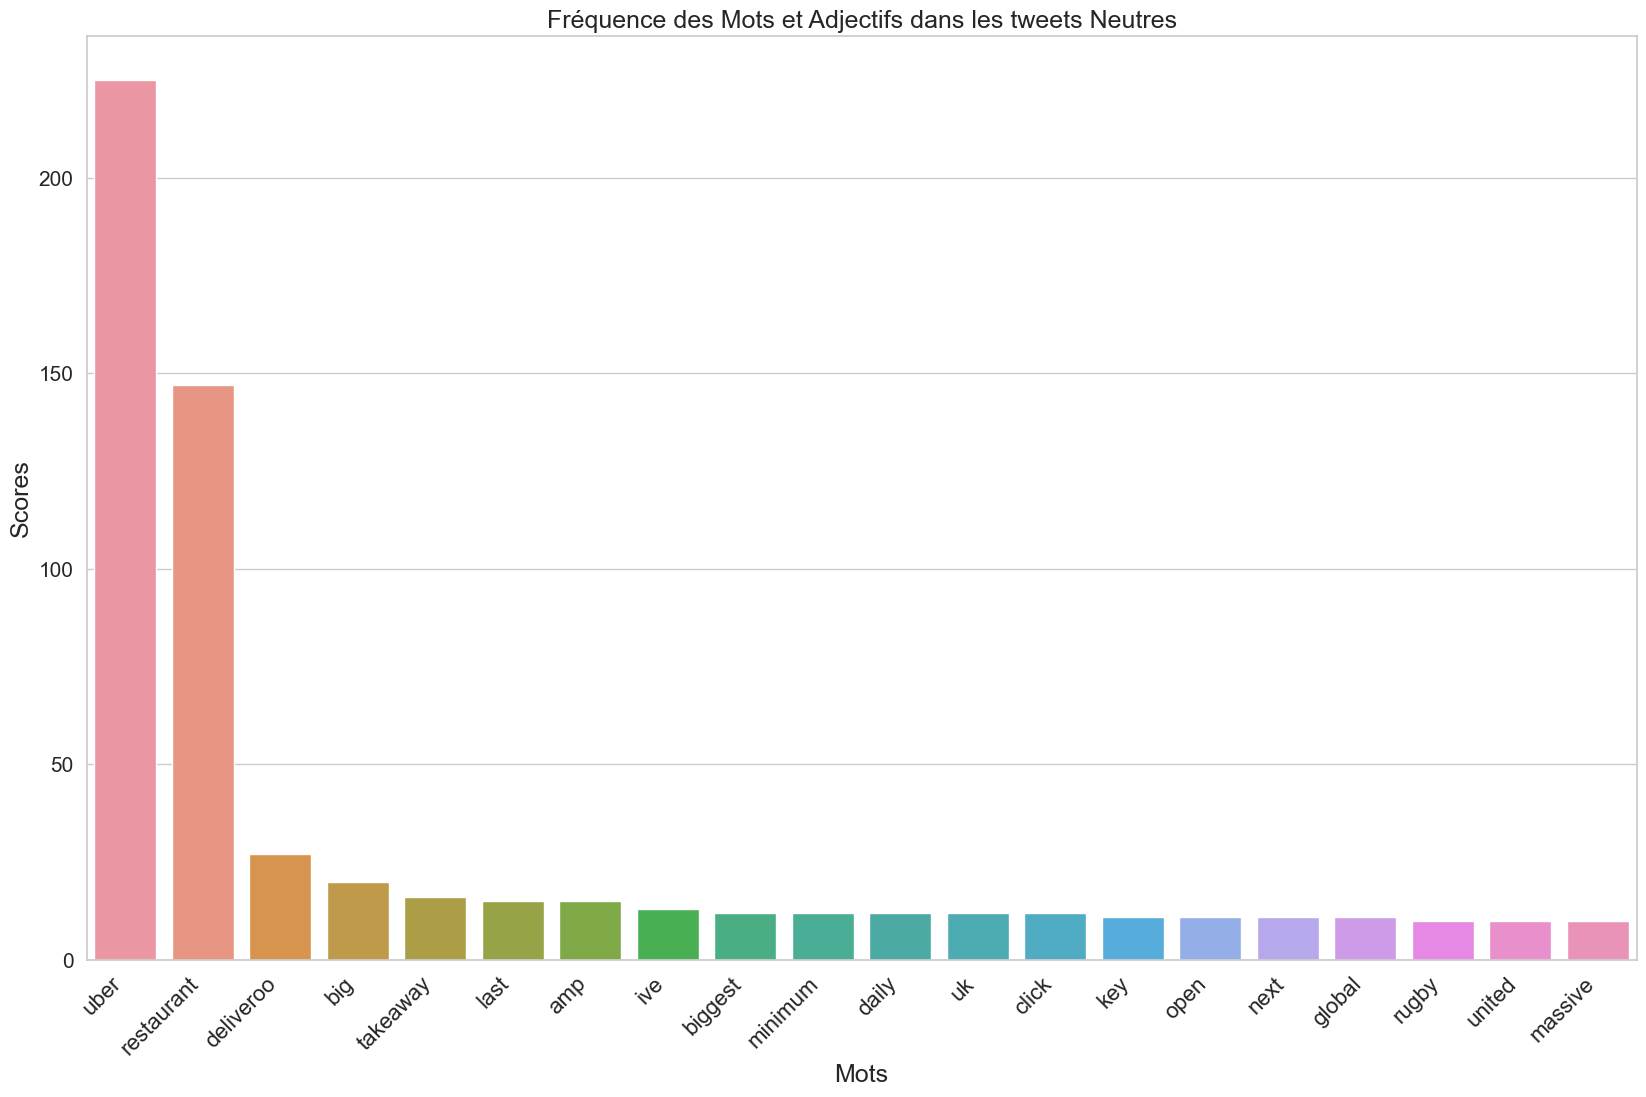

In [77]:
plt.figure(figsize=(20,12))
sns.barplot(x='words',y='scores',data=neu_df)
plt.title('Fréquence des Mots et Adjectifs dans les tweets Neutres', fontsize=18)
plt.xlabel('Mots', fontsize=18)  
plt.ylabel('Scores', fontsize=18)


plt.xticks(rotation=45, fontsize=16, ha='right') 
plt.yticks(fontsize=15) 
plt.savefig('AdjNeut.png', bbox_inches='tight')
plt.show()


# APPROCHES BASEES SUR LE LEXIQUE

### 1) VADER

In [78]:
# Analyse de sentiment sur les tweets tokenisés (ref: https://github.com/Khailas12/Sentiment-Analyzer-NLTK/blob/main/sentiment.py)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sentimentanalyzer = SentimentIntensityAnalyzer()

def VaderSentiment(text):
    vader_score = sentimentanalyzer.polarity_scores(text)['compound']
    if vader_score >  0:
      return  'Positive'
    elif vader_score == 0: 
      return 'Neutral'
    else :
      return 'Negative'

# Appliquer l'analyse de sentiment VADER sur les textes tokenisé
dataset['Vader'] = dataset['TexteEmoji'].apply(VaderSentiment)

# Afficher les étiquettes de sentiment VADER pour vérifier
print(dataset[['TexteEmoji', 'Sentiment_Cible', 'Vader']].head())

                                          TexteEmoji Sentiment_Cible     Vader
0                      orders uber eats place street         Neutral   Neutral
1                               uber eats going fees         Neutral   Neutral
2  london actually isnt real wdym uber eats drive...        Positive   Neutral
3  everytime tip extra uber eats food gets delive...        Negative  Negative
4          uber eats driver said name popped tequila         Neutral   Neutral



Répartition des sentiments avec vader Texte Normalisé


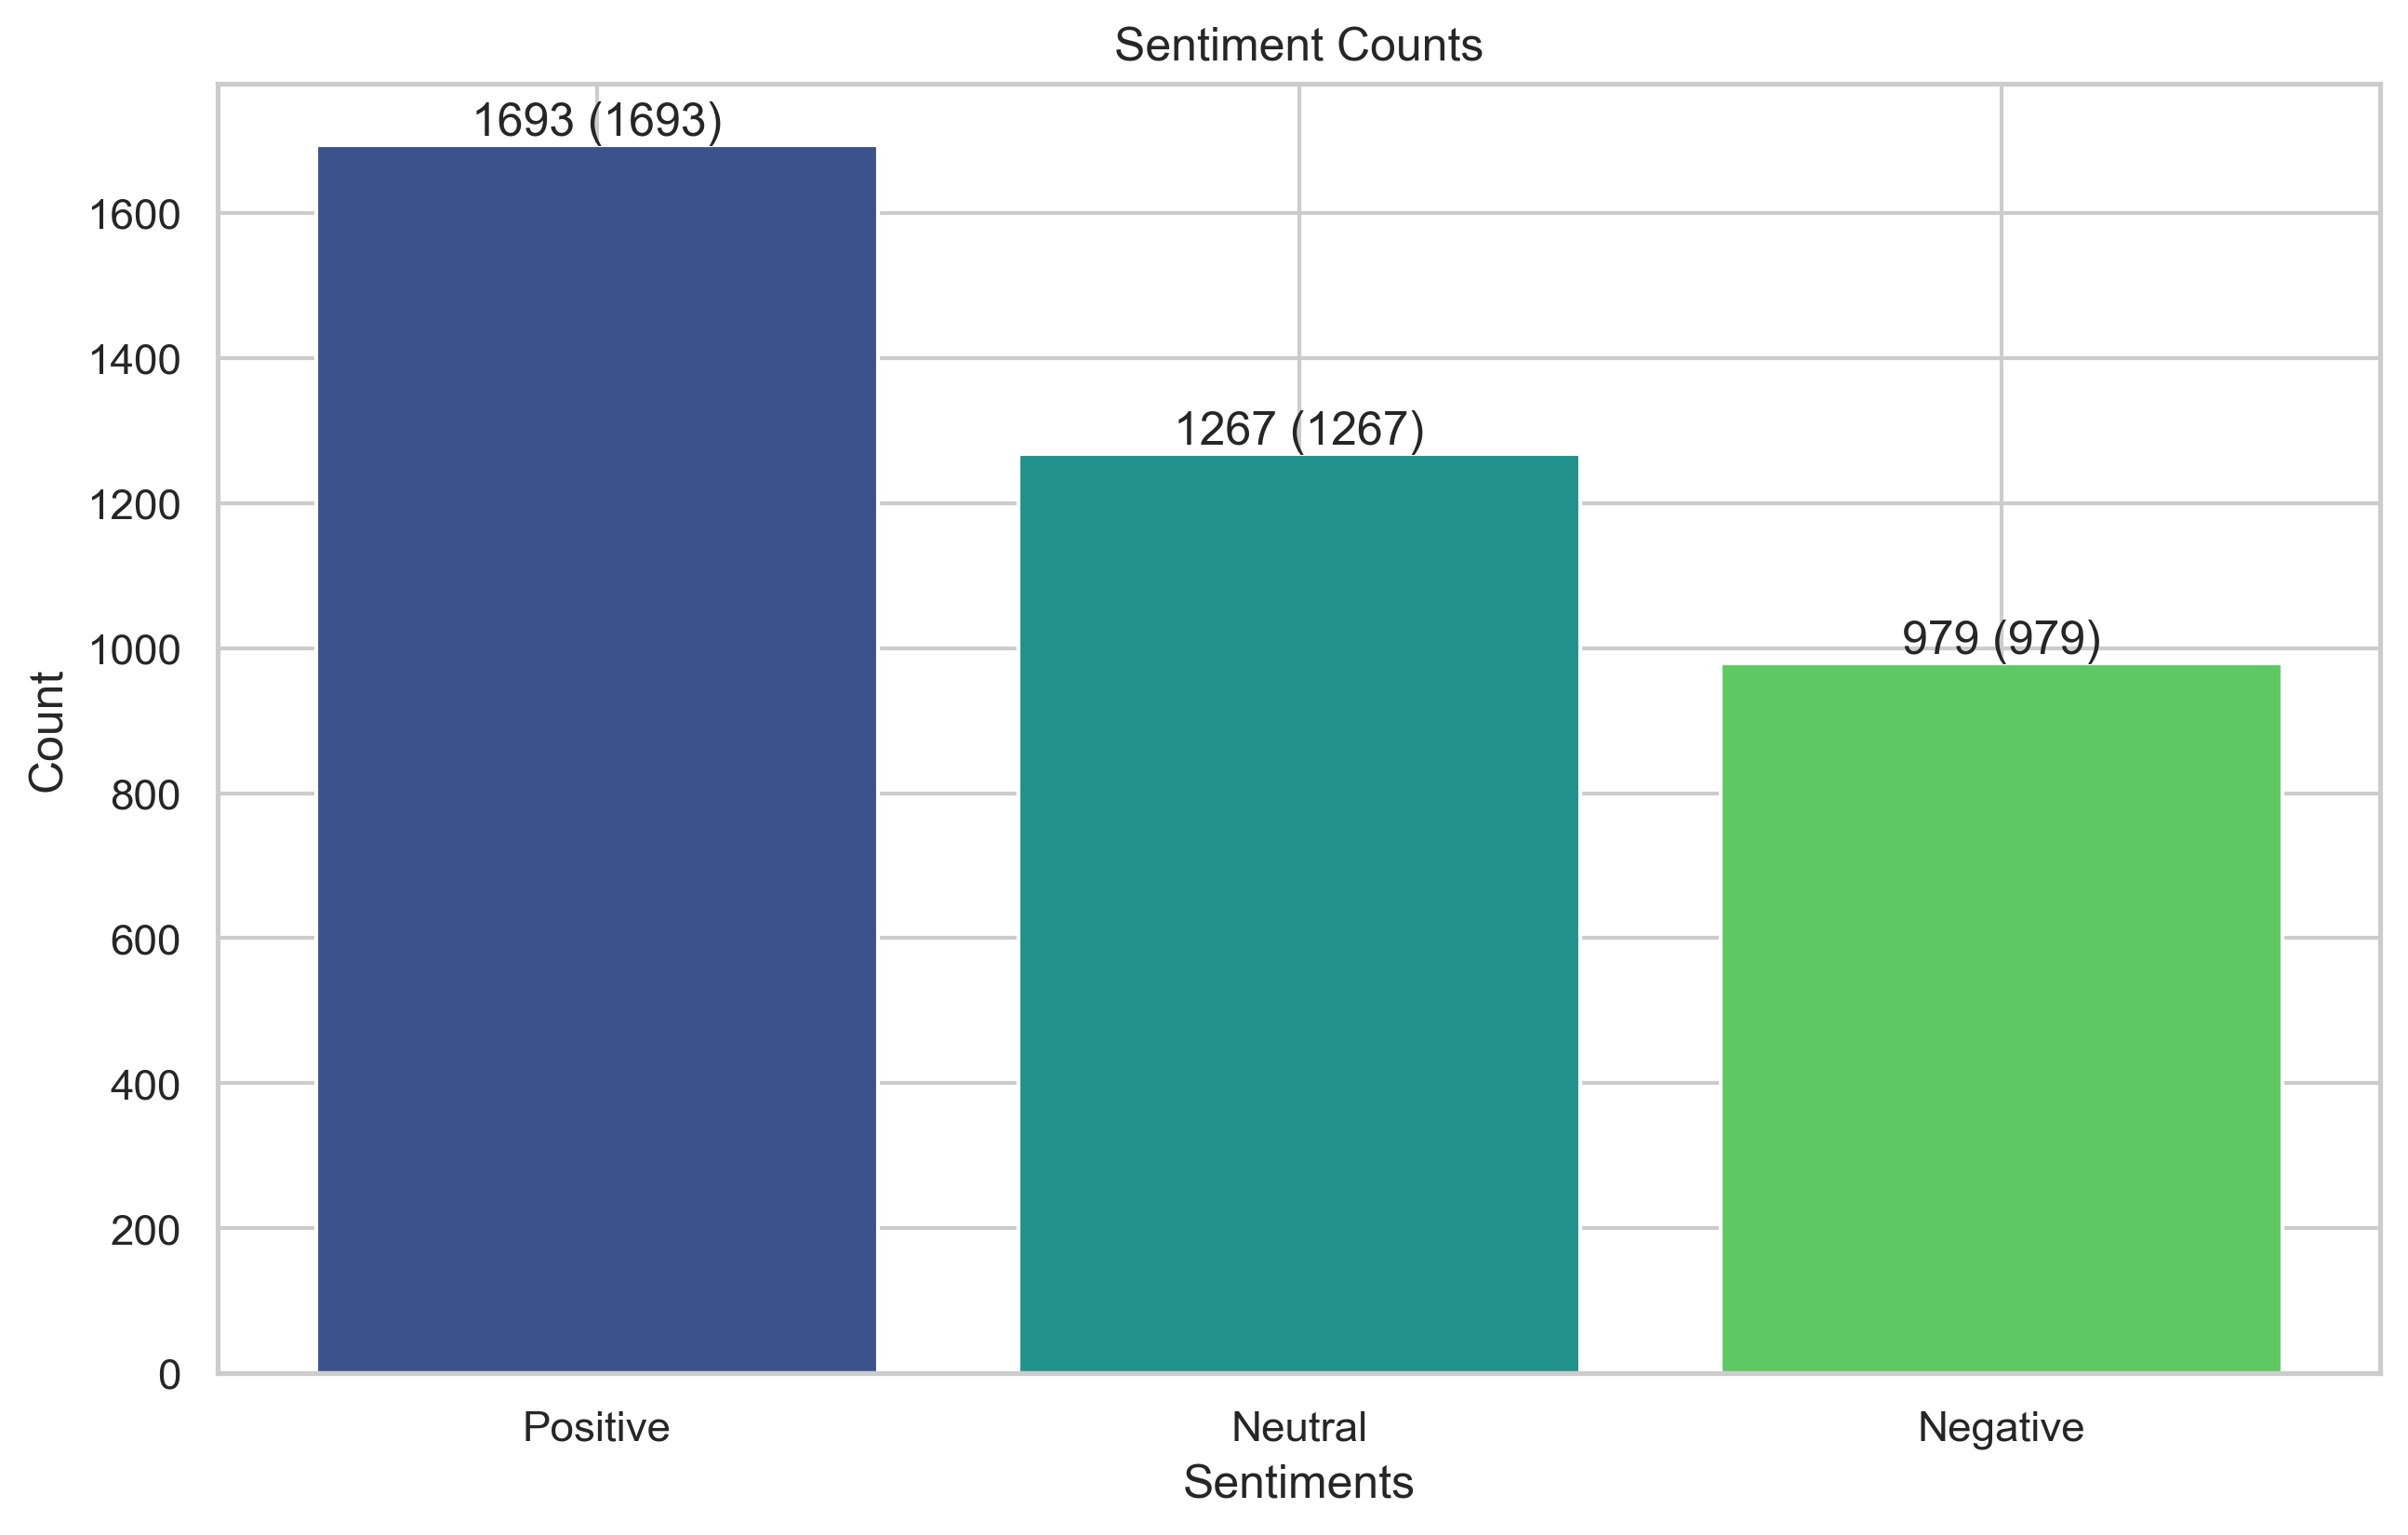

In [79]:
#Création du graphique

sns.set(style='whitegrid')

# Compter le nombre d'occurrences pour chaque sentiment
sentivader_counts = dataset['Vader'].value_counts() 

# Calculer la proportion pour chaque valeur de sentiments
sentivader_proportion = dataset['Vader'].value_counts()

# créer un graphique en bare
plt.figure(figsize=(10,6), dpi=300)
plt.bar(sentivader_counts.index, sentivader_counts.values,color=sns.color_palette('viridis', len (sentivader_counts)))

for i, count in enumerate(sentivader_counts):
    proportion = sentivader_proportion[i]
    plt.text(i, count, f"{count} ({proportion:})", ha='center', va='bottom')
     
# labéliser le graphique
plt.xlabel('Sentiments')
plt.ylabel('Count')
plt.title('Sentiment Counts')
plt.savefig('VADER.png', dpi=300)
print("\nRépartition des sentiments avec vader Texte Normalisé")


# Show the bar graph
plt.show()


### a) Evaluation de Vader

In [80]:
# Calcul des métriques d'évaluation (ref: https://github.com/LeCoinStat/100JoursDeML/blob/main/08_NLP/01_Analyse_Sentiment/01_Twitter_Sentiment_Analysis.ipynb)
accuracy = accuracy_score(dataset['Sentiment_Cible'], dataset['Vader'])  
precision = precision_score(dataset['Sentiment_Cible'], dataset['Vader'], average='weighted')
recall = recall_score(dataset['Sentiment_Cible'], dataset['Vader'], average='weighted')
f1 = f1_score(dataset['Sentiment_Cible'], dataset['Vader'], average='weighted')


# Créer un tableau des performances
performance = pd.DataFrame({
    'Métriques': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Scores': [accuracy, precision, recall, f1]
})

# Afficher la table des performances
print("Performance du classificateur VADER :")
print(performance)

Performance du classificateur VADER :
   Métriques    Scores
0   Accuracy  0.610815
1  Precision  0.627990
2     Recall  0.610815
3   F1 Score  0.616195


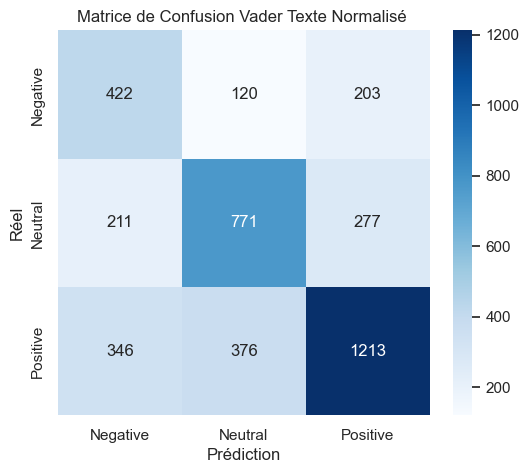

In [83]:
# Générer la matrice de confusion sur la forme de heatmap (ref: https://github.com/Tarun-Kamboj/Data_Visualization_with_Python/blob/master/Code/Confusion%20Matrix/Notebook.ipynb)

matrice_Confusion = pd.crosstab(dataset['Sentiment_Cible'], dataset['Vader'], rownames=['Réel'], colnames=['Prédiction'])
plt.figure(figsize=(6,5))
sns.heatmap(matrice_Confusion, annot=True, fmt="d",  cmap="Blues")
plt.title("Matrice de Confusion Vader Texte Normalisé ", fontsize=12)
plt.savefig('MatriceVADER.png', dpi=200)
plt.show()

### 2) SentiWordNet

In [84]:
from nltk.tokenize import word_tokenize
from nltk.corpus import sentiwordnet as swn, wordnet
import pandas as pd
import nltk

nltk.download('sentiwordnet')
nltk.download('punkt')
nltk.download('wordnet')

# Calculer le score des sentiments (ref: https://stackoverflow.com/questions/38263039/sentiwordnet-scoring-with-python)
# Tokenize le dataset
dataset = dataset.copy()
dataset['Tokens'] = dataset['TexteEmoji'].apply(word_tokenize)

def WordnetSentiment(tokens):
    sentiment_scores = []
    for token in tokens:
        synsets = wordnet.synsets(token)
        if synsets:
            swn_synset = swn.senti_synset(synsets[0].name())
            sentiment_scores.append((swn_synset.pos_score(), swn_synset.neg_score()))
        else:
            sentiment_scores.append((0, 0))  # Scores neutres si aucun synset n'est trouvé
    return sentiment_scores

# Appliquer SentiWordNet sur chaque liste de tokens pour obtenir les scores de sentiment
dataset['WordNet'] = dataset['Tokens'].apply(WordnetSentiment)

# Afficher les résultats
print(dataset[['TexteEmoji','Sentiment_Cible', 'WordNet']].head())


[nltk_data] Downloading package sentiwordnet to C:\Users\Freddine
[nltk_data]     Djoutchet\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Freddine
[nltk_data]     Djoutchet\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Freddine
[nltk_data]     Djoutchet\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                          TexteEmoji Sentiment_Cible  \
0                      orders uber eats place street         Neutral   
1                               uber eats going fees         Neutral   
2  london actually isnt real wdym uber eats drive...        Positive   
3  everytime tip extra uber eats food gets delive...        Negative   
4          uber eats driver said name popped tequila         Neutral   

                                             WordNet  
0  [(0.0, 0.0), (0, 0), (0.0, 0.0), (0.0, 0.0), (...  
1       [(0, 0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0)]  
2  [(0.0, 0.0), (0.375, 0.0), (0, 0), (0.0, 0.0),...  
3  [(0, 0), (0.0, 0.0), (0.0, 0.0), (0, 0), (0.0,...  
4  [(0, 0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (...  


In [85]:
# Calculer une Mesure Globale de Sentiment
def globalSentiment(scores):
    pos_sum = sum(score[0] for score in scores)
    neg_sum = sum(score[1] for score in scores)
    if pos_sum > neg_sum:
        return 'Positive'
    elif neg_sum > pos_sum:
        return 'Negative'
    else:
        return 'Neutral'
# Appliquer cette fonction pour obtenir une catégorie de sentiment globale pour chaque tweet
dataset['Classe_Sentiment'] = dataset['WordNet'].apply(globalSentiment)

#print("{}:".format(word))


Répartition des sentiments avec SentiWordNet Texte Normalisé:


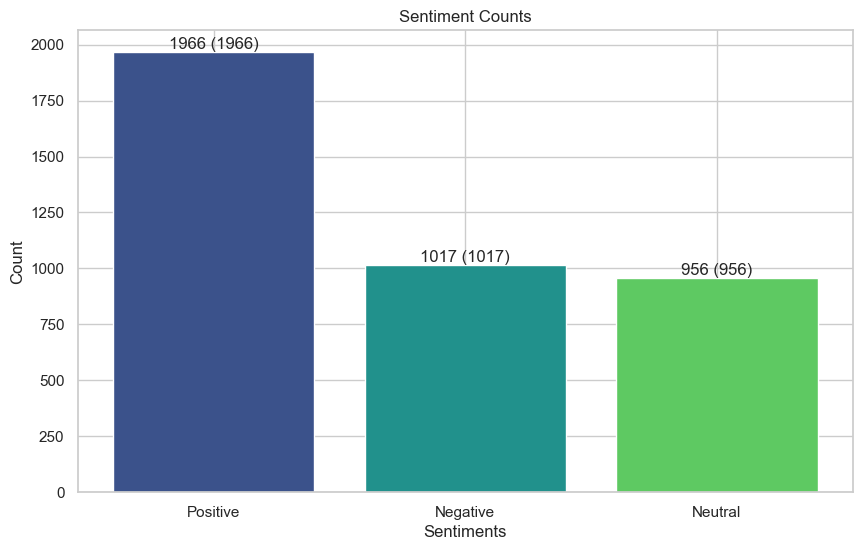

In [86]:
#Création du graphique
sns.set(style='whitegrid')

# Compter le nombre d'occurrences pour chaque sentiment
sentiwordnet_counts = dataset['Classe_Sentiment'].value_counts() 

# Calculer la proportion pour chaque valeur de sentiments
sentiwordnet_proportion = dataset['Classe_Sentiment'].value_counts()

# créer un graphique en bare
plt.figure(figsize=(10,6))
plt.bar(sentiwordnet_counts.index, sentiwordnet_counts.values,color=sns.color_palette('viridis', len (sentiwordnet_counts)))


# Ajouter les étiquettes des barres (nombre d'occurrences et proportion)
for i, count in enumerate(sentiwordnet_counts):
    proportion = sentiwordnet_proportion[i]
    plt.text(i, count, f"{count} ({proportion:})", ha='center', va='bottom')
     

# labéliser le graphique
plt.xlabel('Sentiments')
plt.ylabel('Count')
plt.title('Sentiment Counts')
plt.savefig('SentiWordnet.png', dpi=300)
print("\nRépartition des sentiments avec SentiWordNet Texte Normalisé:")


# Show the bar graph
plt.show()

### a) Evaluation de SentiWordNet Texte Normalisé

In [87]:
# Calcul des métriques d'évaluation (ref: https://github.com/LeCoinStat/100JoursDeML/blob/main/08_NLP/01_Analyse_Sentiment/01_Twitter_Sentiment_Analysis.ipynb)
accuracy = accuracy_score(dataset['Sentiment_Cible'], dataset['Classe_Sentiment'])  
precision = precision_score(dataset['Sentiment_Cible'], dataset['Classe_Sentiment'], average='weighted')
recall = recall_score(dataset['Sentiment_Cible'], dataset['Classe_Sentiment'], average='weighted')
f1 = f1_score(dataset['Sentiment_Cible'], dataset['Classe_Sentiment'], average='weighted')


# Créer un tableau des performances
performance = pd.DataFrame({
    'Métriques': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Scores': [accuracy, precision, recall, f1]
})

# Afficher la table des performances
print("Performance du classificateur SentiWordNet Texte Normalisé :")
print(performance)

Performance du classificateur SentiWordNet Texte Normalisé :
   Métriques    Scores
0   Accuracy  0.526022
1  Precision  0.542101
2     Recall  0.526022
3   F1 Score  0.529267


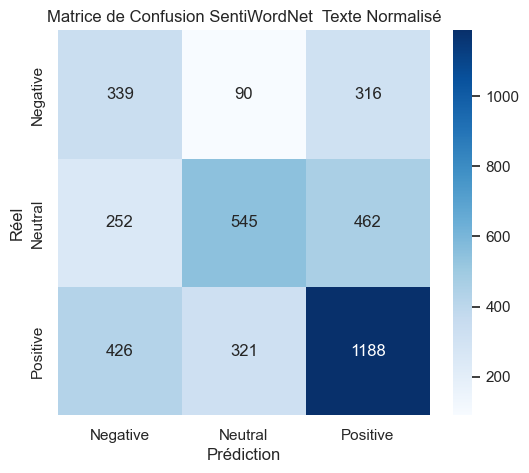

In [88]:
# Générer la matrice de confusion sur la forme de heatmap (ref: https://github.com/Tarun-Kamboj/Data_Visualization_with_Python/blob/master/Code/Confusion%20Matrix/Notebook.ipynb)

matrice_Confusion = pd.crosstab(dataset['Sentiment_Cible'], dataset['Classe_Sentiment'], rownames=['Réel'], colnames=['Prédiction'])
plt.figure(figsize=(6,5))
sns.heatmap(matrice_Confusion, annot=True, fmt="d",  cmap="Blues")
plt.title("Matrice de Confusion SentiWordNet  Texte Normalisé", fontsize=12)
plt.savefig('MatriceSentiWordnet.png', dpi=200)
plt.show()

# APPROCHES BASEES SUR L'APPRENTISSAGE SUPERVISE

### 1) Conversion des données en numériques

In [315]:
# (ref: #(ref: https://github.com/LeCoinStat/100JoursDeML/blob/main/08_NLP/01_Analyse_Sentiment/01_Twitter_Sentiment_Analysis.ipynb))
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Créer une instance du vectoriseur TfidfVectorizer
tfidfvectorization = TfidfVectorizer(
analyzer='word',
strip_accents='unicode',
token_pattern=r'\w{2,}',
ngram_range=(1,1),
max_features= 4500
)

# Appliquer le vectoriseur sur la variable nettoyé
caracteristiques = tfidfvectorization.fit_transform(dataset['TexteEmoji'])

# Convertir les caractéristiques en une représentation de matrice creuse
caracteristiques = caracteristiques.toarray()

# Afficher les dimensions de la matrice de caractéristiques
print("Dimensions de la matrice de caractéristiques :", caracteristiques.shape)
caracteristiques

Dimensions de la matrice de caractéristiques : (3939, 4500)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [316]:
#Transformation des etiquettes de sentiments en valeur numérique pour l'entraînement des models (https://github.com/kenypatel233/SentimentAnalysis/blob/main/Sentiment%20Analysis.ipynb)
from sklearn.preprocessing import LabelEncoder

Outputdataset = pd.DataFrame(dataset["Sentiment_Cible"])

# Initialisation de LabelEncoder
Etiquette_Numeric = LabelEncoder()
#transformer les sentiments en  valeur numérique
Outputdataset ['Sentiment_Cible']= Etiquette_Numeric.fit_transform(Outputdataset['Sentiment_Cible'])
Outputdataset

,Sentiment_Cible
0,1
1,1
2,2
3,0
4,1
...,...
3934,0
3935,0
3936,0
3937,2


### 2) Le modèle Logistique Regression  Texte Normalisé

In [317]:
# Division des données pour l'entraînement (ref:https://github.com/LeCoinStat/100JoursDeML/blob/main/08_NLP/01_Analyse_Sentiment/01_Twitter_Sentiment_Analysis.ipynb )
from sklearn.model_selection import train_test_split
# Diviser les données en ensembles d'entraînement et de test de façon stratifiée
X_train, X_test, y_train, y_test = train_test_split(caracteristiques, Outputdataset['Sentiment_Cible'], test_size=0.2, stratify=Outputdataset['Sentiment_Cible'], random_state=42)
print("Training:", len(X_train))
print("Test :", len(X_test))

Training: 3151
Test : 788


In [318]:
# Création et entraînement du modèle de régression logistique multinomiale (ref: https://github.com/sundeeppothula1993/Multi-class-classification/blob/master/Multi-class%2BClassification.ipynb)
Regression_logistic = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000, random_state=42)
Regression_logistic.fit(X_train, y_train)

# Prédiction des sentiments sur l'ensemble de test
Prediction = Regression_logistic.predict(X_test)

# Afficher les prédictions
print("Prédictions avec la Regression Logistique:")
print(Prediction)

Prédictions avec la Regression Logistique:
[2 2 2 1 1 2 1 2 1 2 1 2 2 1 1 2 2 2 1 2 2 0 1 2 2 2 0 2 2 2 2 2 1 2 1 2 2
 1 2 2 2 1 2 0 2 2 2 2 1 1 2 1 1 2 2 2 0 2 2 1 2 2 2 2 1 2 2 2 2 1 2 1 2 2
 2 0 1 1 2 1 2 1 1 2 1 2 2 1 2 1 2 1 1 2 1 1 2 1 1 2 2 1 0 2 1 2 1 2 2 1 1
 2 2 1 0 2 1 2 0 2 2 2 2 2 2 2 1 2 1 2 2 1 2 1 1 2 2 0 2 1 2 2 2 0 2 2 2 2
 1 2 1 2 2 1 2 2 2 2 1 0 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 1 1 2 2
 2 1 2 2 2 2 0 0 2 1 2 0 2 1 0 1 2 0 2 1 2 0 2 2 0 2 2 2 2 2 2 2 2 2 1 2 2
 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 1 2 2 2 2 2 1 2 2 1 2 2 1 1 1 2 0 2 0 2 2 0
 0 2 1 0 2 1 1 1 1 2 2 2 1 2 2 2 2 0 2 0 2 1 1 1 2 2 1 2 2 2 0 2 2 2 2 1 2
 1 0 2 1 2 2 2 1 2 1 2 2 2 0 2 2 2 2 2 1 2 2 2 2 1 2 0 1 2 2 0 1 2 1 2 1 2
 1 2 1 2 1 1 2 2 2 1 1 2 1 2 1 1 2 2 2 2 2 1 2 1 2 2 2 1 2 2 1 2 2 1 2 2 2
 1 1 1 2 1 2 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 2 1 1 2 2 2 2 2 0 2 2 2 2 2 2 2
 2 2 1 1 1 1 0 2 1 2 2 2 2 2 2 1 1 1 2 2 1 1 2 2 2 2 2 2 1 2 2 2 2 1 2 2 1
 1 2 0 2 2 2 1 1 1 0 2 2 2 2 2 2 1 2 2 0 2 2 2 2 2 1 2 1 

### a) Evaluation de Logistique Regression

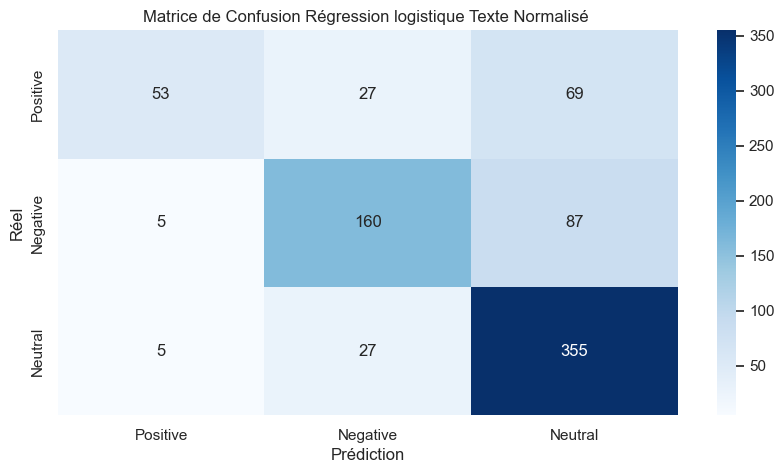

In [320]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Génération des prédictions
Prediction = Regression_logistic.predict(X_test)
matrice_Confusion = confusion_matrix(y_test, Prediction)

class_names = ["Positive", "Negative", "Neutral"]
plt.figure(figsize=(10,5))
sns.heatmap(matrice_Confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Matrice de Confusion Régression logistique Texte Normalisé ", fontsize=12)
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.savefig('MatriceRLO.png', dpi=100)
plt.show()

In [321]:
# Prédictions sur les ensembles d'entraînement et de test
predictionTrain = Regression_logistic.predict(X_train)
predictionTest = Regression_logistic.predict(X_test)

# Calculer les performances sur les ensembles d'entraînement et de test
trainAccuracy = accuracy_score(y_train, predictionTrain)
trainPrecision = precision_score(y_train, predictionTrain, average='weighted')
trainRecall = recall_score(y_train, predictionTrain, average='weighted')
trainF1 = f1_score(y_train, predictionTrain, average='weighted')

testAccuracy = accuracy_score(y_test, predictionTest)
testPrecision = precision_score(y_test, predictionTest, average='weighted')
testRecall = recall_score(y_test, predictionTest, average='weighted')
testF1 = f1_score(y_test, predictionTest, average='weighted')

# Créer un tableau des performances
performance = pd.DataFrame({
    'Performance': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [trainAccuracy, trainPrecision, trainRecall, trainF1],
    'Test': [testAccuracy, testPrecision, testRecall, testF1]
})
print("Performance du model Régression Logistique Texte Normalisé")
print(performance)

Performance du model Régression Logistique Texte Normalisé
  Performance    Train      Test
0    Accuracy  0.91590  0.720812
1   Precision  0.92282  0.739360
2      Recall  0.91590  0.720812
3    F1 Score  0.91407  0.702446


### 3) Le clasificateur Support Vecteur Machine Multiclasse Texte Normalisé (SVM) 

In [322]:
# Division des données pour l'entraînement (ref:https://github.com/LeCoinStat/100JoursDeML/blob/main/08_NLP/01_Analyse_Sentiment/01_Twitter_Sentiment_Analysis.ipynb )
from sklearn.model_selection import train_test_split
# Diviser les données en ensembles d'entraînement et de test de façon stratifiée
X_train, X_test, y_train, y_test = train_test_split(caracteristiques, Outputdataset['Sentiment_Cible'], test_size=0.2, stratify=Outputdataset['Sentiment_Cible'], random_state=42)
print("Training:", len(X_train))
print("Test :", len(X_test))

Training: 3151
Test : 788


In [323]:
# Création et entraînement du model SVM Multiclasse(ref: https://ichi.pro/fr/classification-svm-entierement-expliquee-avec-python-261276359556045)
from sklearn.svm import SVC
# Création et entraînement du modèle SVM pour la classification multiclasses
SVM_Multiclass = SVC(kernel='linear', decision_function_shape='ovo', random_state=42)
SVM_Multiclass.fit(X_train, y_train)

# Prédiction des sentiments sur l'ensemble de test
SVM_Multiclass_prediction = SVM_Multiclass.predict(X_test)

# Afficher les prédictions
print("Prédictions des sentiments avec SVM Texte Normalisé")
print(SVM_Multiclass_prediction)

Prédictions des sentiments avec SVM Texte Normalisé
[2 2 2 1 1 2 2 0 1 2 1 2 2 1 1 1 2 2 1 2 2 0 1 0 0 2 0 0 2 2 2 2 1 2 1 2 2
 1 2 2 2 1 2 0 0 2 2 2 1 1 2 1 1 2 2 1 0 2 2 1 2 2 2 2 1 2 2 2 2 1 2 1 2 2
 2 0 1 1 2 1 2 1 1 2 1 2 2 1 2 1 1 1 1 2 1 2 2 1 1 2 2 1 0 2 1 2 1 2 2 1 1
 2 2 1 0 2 1 2 0 2 2 2 1 2 2 2 1 2 1 0 2 1 2 1 1 2 2 0 2 1 2 2 2 0 2 2 2 1
 1 2 1 2 2 1 1 2 2 2 1 0 1 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 1 1 1 2 2
 2 1 2 2 2 1 0 0 2 1 2 0 2 1 0 1 2 0 0 1 2 0 2 2 0 2 2 2 2 2 2 2 1 2 1 2 2
 2 2 2 1 2 2 2 0 2 1 2 2 1 2 2 1 1 2 1 2 2 1 2 2 1 1 2 1 1 1 2 0 2 0 2 2 2
 0 2 1 0 2 1 1 1 1 2 2 2 1 2 2 2 2 0 2 0 2 1 1 1 2 2 1 2 2 2 0 2 2 2 2 1 2
 1 2 2 1 2 1 2 1 2 1 2 2 2 0 2 1 2 2 2 1 0 2 2 2 1 2 0 1 2 2 0 1 2 1 2 1 1
 1 2 1 1 1 1 2 2 2 1 1 2 1 2 1 1 0 2 0 2 2 1 2 1 2 2 2 1 2 2 1 2 2 1 2 2 1
 1 1 1 2 1 2 2 2 2 2 1 2 0 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2 2 0 2 2 2 2 2 2 2
 2 2 1 1 1 1 0 1 1 2 2 2 2 2 2 1 1 1 2 2 1 1 2 2 2 2 2 1 1 2 2 2 2 1 2 2 1
 1 2 0 2 2 2 1 1 1 0 2 2 2 2 2 2 1 2 2 0 2 0 2 2

### a) Evaluation du model SVM Texte Normalisé

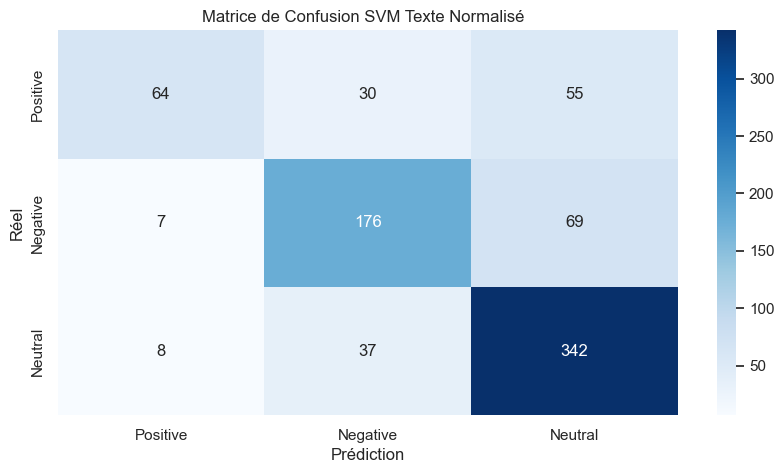

In [324]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Génération des prédictions
SVM_Multiclass_prediction = SVM_Multiclass.predict(X_test)
matrice_Confusion = confusion_matrix(y_test, SVM_Multiclass_prediction)

class_names = ["Positive", "Negative", "Neutral"]
plt.figure(figsize=(10,5))
sns.heatmap(matrice_Confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Matrice de Confusion SVM Texte Normalisé  ", fontsize=12)
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.savefig('MatriceSVM.png', dpi=100)
plt.show()

In [325]:
# Prédictions sur les ensembles d'entraînement et de test
predictionTrain = SVM_Multiclass.predict(X_train)
predictionTest = SVM_Multiclass.predict(X_test)

# Calculer les performances sur les ensembles d'entraînement et de test
trainAccuracy = accuracy_score(y_train, predictionTrain)
trainPrecision = precision_score(y_train, predictionTrain, average='weighted')
trainRecall = recall_score(y_train, predictionTrain, average='weighted')
trainF1 = f1_score(y_train, predictionTrain, average='weighted')

testAccuracy = accuracy_score(y_test, predictionTest)
testPrecision = precision_score(y_test, predictionTest, average='weighted')
testRecall = recall_score(y_test, predictionTest, average='weighted')
testF1 = f1_score(y_test, predictionTest, average='weighted')

# Créer un tableau des performances
performance = pd.DataFrame({
    'Performance': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [trainAccuracy, trainPrecision, trainRecall, trainF1],
    'Test': [testAccuracy, testPrecision, testRecall, testF1]
})
print("Performance du model SVM Texte Normalisé:")
print(performance)

Performance du model SVM Texte Normalisé:
  Performance     Train      Test
0    Accuracy  0.953983  0.738579
1   Precision  0.954941  0.745240
2      Recall  0.953983  0.738579
3    F1 Score  0.953639  0.727379


In [326]:
from prettytable import PrettyTable 

pretty_table = PrettyTable()
# Ajout des en-têtes
pretty_table.field_names = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
# VADER
pretty_table.add_row(['VADER', '0.610815', '0.627990', '0.610815', '0.616195'])
# SentiWordNe
pretty_table.add_row(['SentiWordNet', '0.526022', '0.542101 ', '0.526022', '0.529267'])
# Régression Logistique
pretty_table.add_row(['Logistic Regression', '0.720812', '0.739360', '0.720812', '0.702446'])
# SVM
pretty_table.add_row(['SVM', '0.738579', '0.745240', '0.738579', '0.727379'])

print("\nPerformances détaillées de chaque modèle :")
print(pretty_table)

# Identifier le meilleur modèle en termes d'accuracy
max_accuracy = max([0.610815, 0.526022, 0.720812, 0.738579])

# Création d'un tableau pour le meilleur modèle
pretty_bestModel = PrettyTable()
pretty_bestModel.field_names = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

# Ajout du meilleur modèle dans le tableau
if max_accuracy == 0.610815:
    pretty_bestModel.add_row(['VADER', '0.610815', '0.627990', '0.610815', '0.616195'])
elif max_accuracy == 0.526022:
    pretty_bestModel.add_row(['SentiWordNet', '0.526022', '0.542101 ', '0.526022', '0.529267'])
elif max_accuracy == 0.720812:
    pretty_bestModel.add_row(['Logistic Regression', '0.720812', '0.739360', '0.720812', '0.702446'])
elif max_accuracy == 0.738579:
    pretty_bestModel.add_row(['SVM', '0.738579', '0.745240', '0.738579', '0.727379'])

print("\nMeilleur modèle :")
print(pretty_bestModel)



Performances détaillées de chaque modèle :
+---------------------+----------+-----------+----------+----------+
|        Model        | Accuracy | Precision |  Recall  | F1 Score |
+---------------------+----------+-----------+----------+----------+
|        VADER        | 0.610815 |  0.627990 | 0.610815 | 0.616195 |
|     SentiWordNet    | 0.526022 | 0.542101  | 0.526022 | 0.529267 |
| Logistic Regression | 0.720812 |  0.739360 | 0.720812 | 0.702446 |
|         SVM         | 0.738579 |  0.745240 | 0.738579 | 0.727379 |
+---------------------+----------+-----------+----------+----------+

Meilleur modèle :
+-------+----------+-----------+----------+----------+
| Model | Accuracy | Precision |  Recall  | F1 Score |
+-------+----------+-----------+----------+----------+
|  SVM  | 0.738579 |  0.745240 | 0.738579 | 0.727379 |
+-------+----------+-----------+----------+----------+


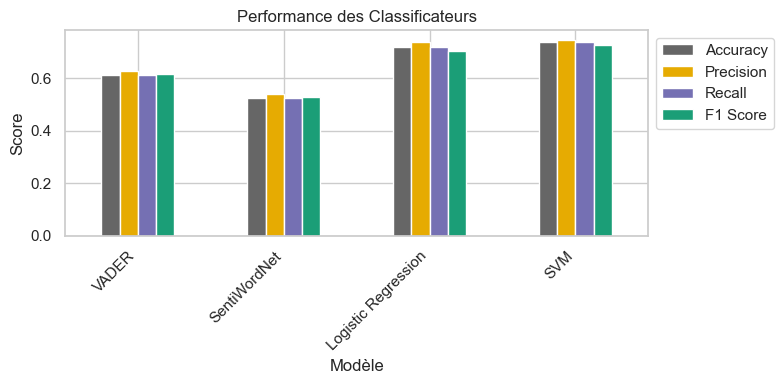

In [331]:
# Résultats des modèles pour chaque métrique
Result_Model = Result_Model = {
    'Model': ['VADER', 'SentiWordNet', 'Logistic Regression', 'SVM'],
    'Accuracy': [0.610815, 0.526022, 0.720812, 0.738579],
    'Precision': [0.627990, 0.542101, 0.739360, 0.745240],
    'Recall': [0.610815, 0.526022, 0.720812, 0.738579],
    'F1 Score': [0.616195, 0.529267, 0.702446, 0.727379]
}

# Créer un DataFrame à partir des résultats des modèles
df_Result_Model = pd.DataFrame(Result_Model)

# Définir la colonne 'Model' comme index pour une meilleure visualisation
df_Result_Model.set_index('Model', inplace=True)

# Tracer le graphique à barres avec les étiquettes d'axe x tournées
ax = df_Result_Model.plot(kind='bar', figsize=(8, 4), colormap='Dark2_r')
plt.title('Performance des Classificateurs')
plt.xlabel('Modèle')
plt.ylabel('Score')
plt.legend(loc='best', bbox_to_anchor=(1.0, 1.0))

# Rotation des étiquettes de l'axe x pour une meilleure lisibilité
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('ComparaisonModel.png', bbox_inches='tight')
plt.show()
